In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import ascii
from scipy import optimize

In [2]:
df_data = ascii.read("datasets/time-curves/2301590/kplr002301590-2009166043257_llc_lc.tbl").to_pandas()

In [3]:
for filename in os.listdir('datasets/time-curves/2301590/'):
    if(filename.endswith('.tbl') and not filename.endswith('2009166043257_llc_lc.tbl')):        
        data = ascii.read('datasets/time-curves/2301590/' + filename).to_pandas()        
        df_data = df_data.append(data)

In [4]:
df_time_flux = df_data[['TIME','PDCSAP_FLUX']].dropna()

In [5]:
sns.set()

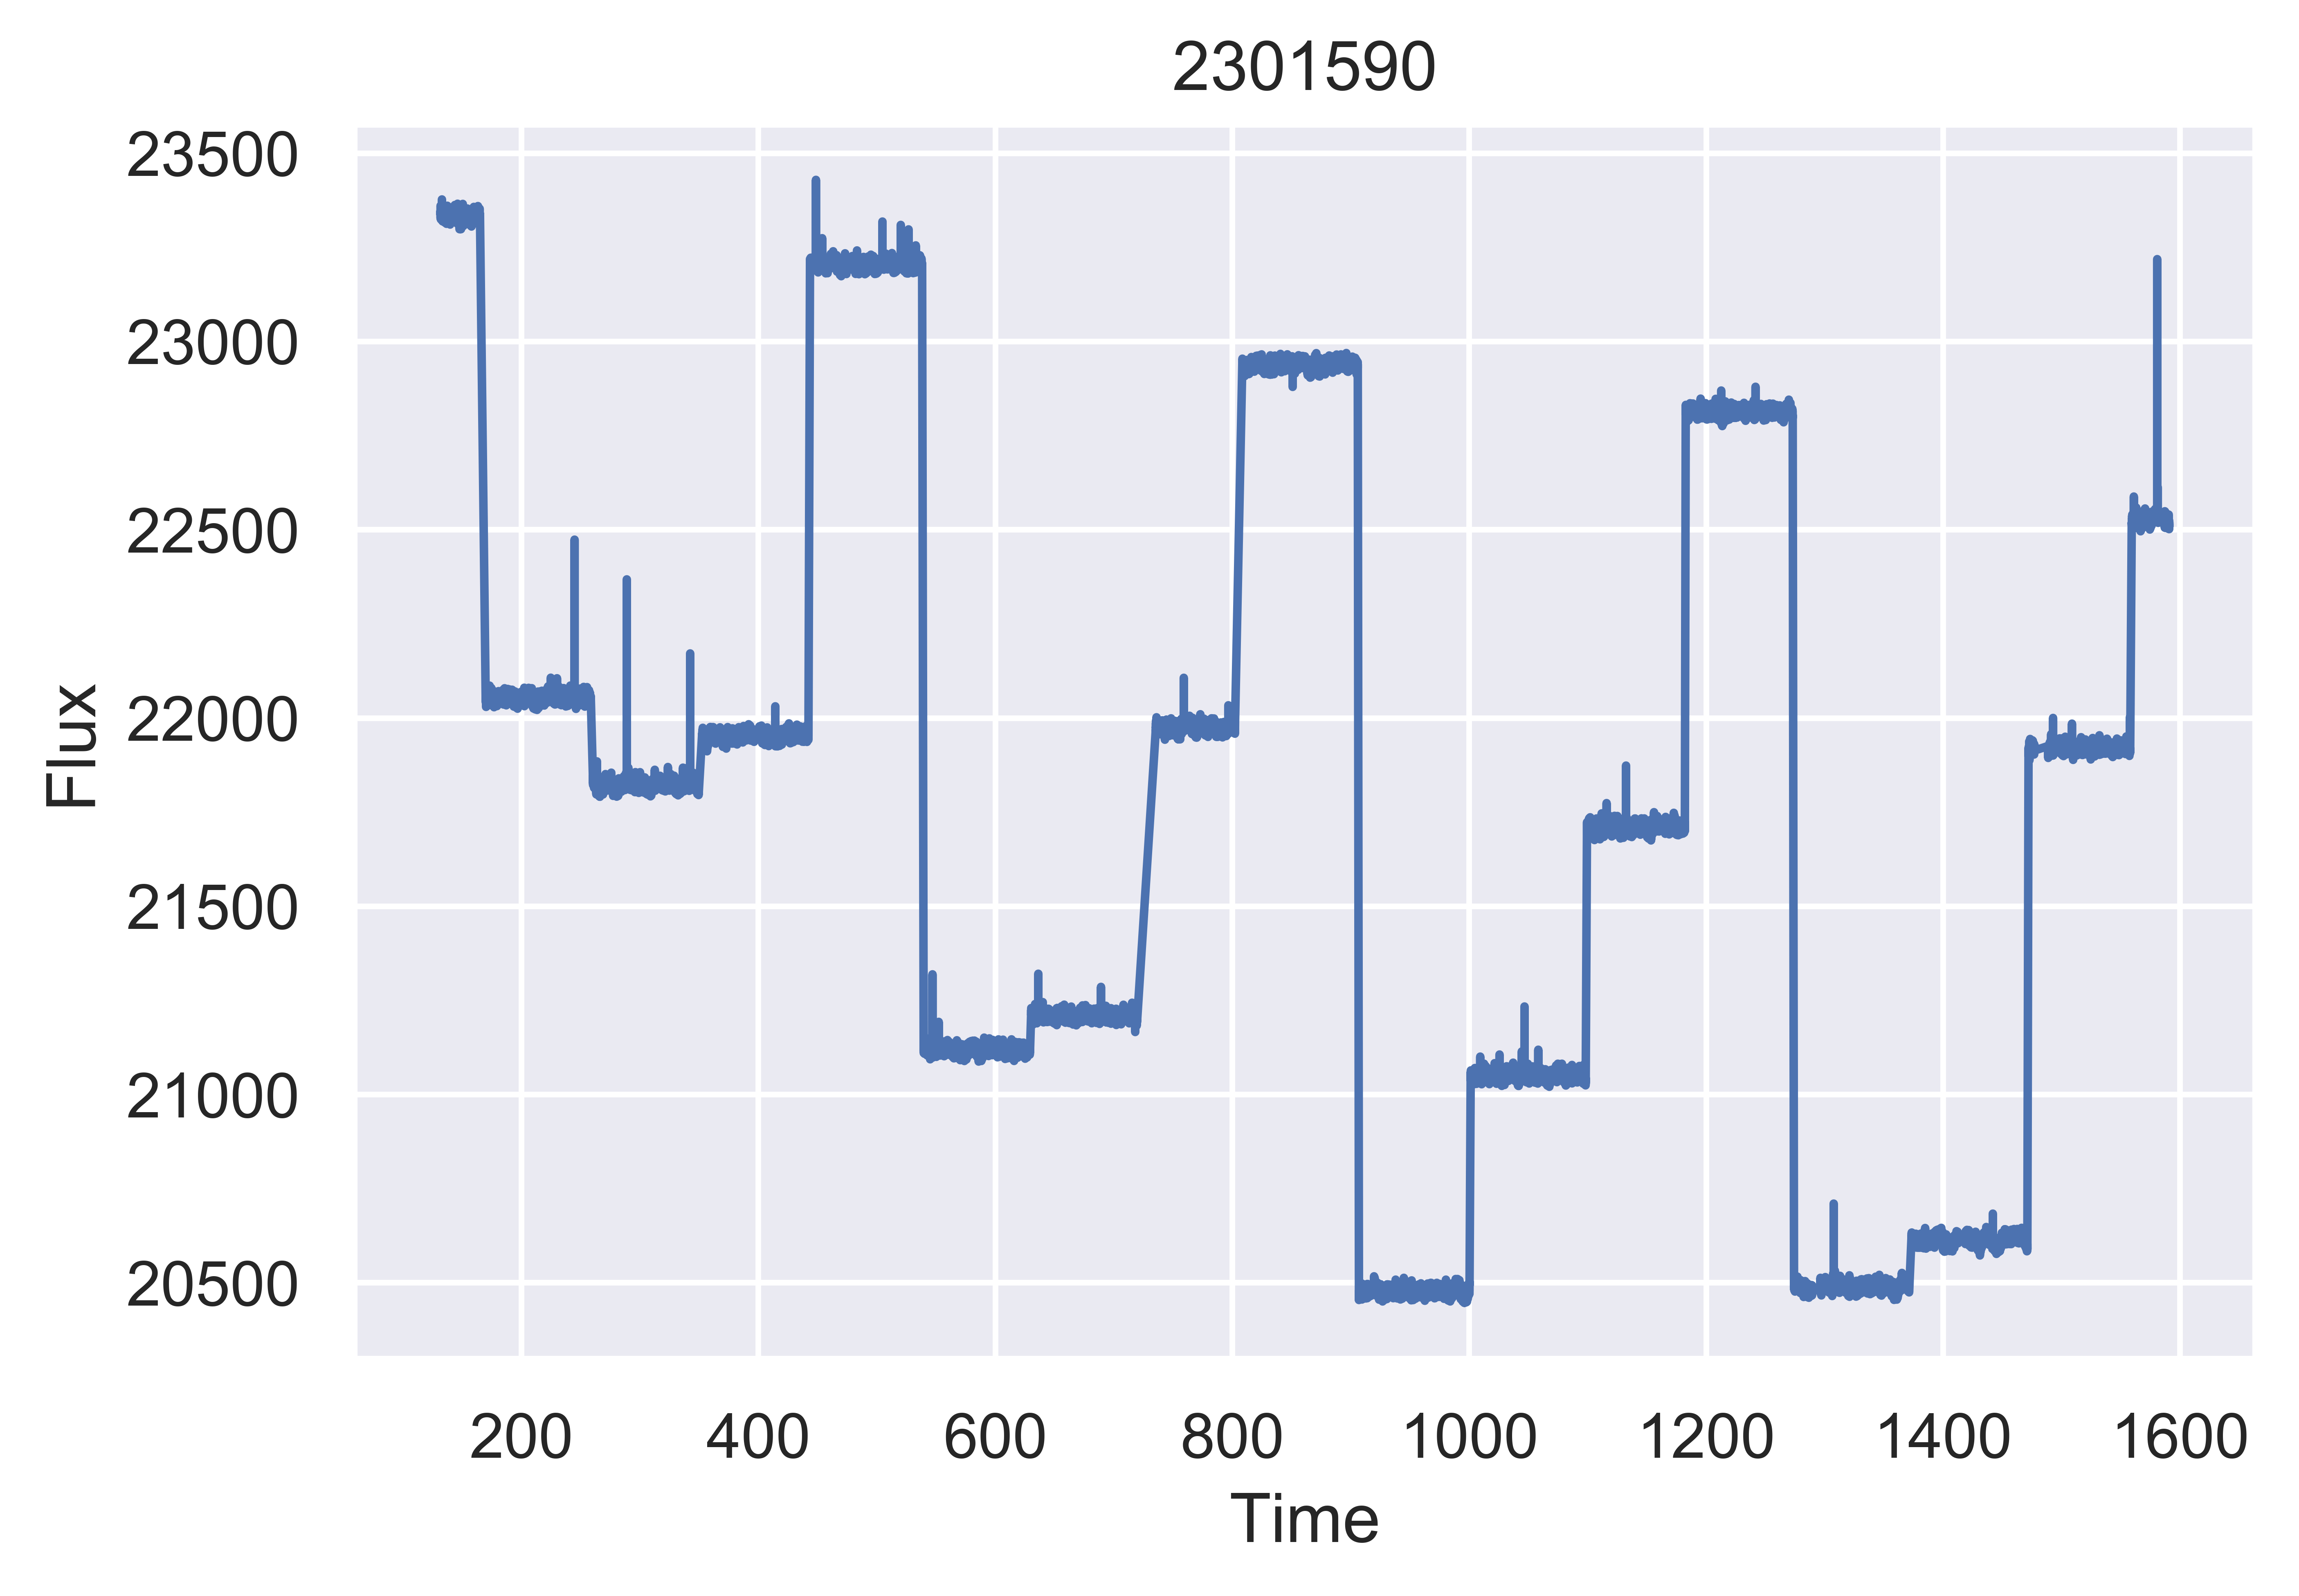

In [6]:
plt.figure(1,dpi=1000)
sns.lineplot(df_time_flux['TIME'],df_time_flux['PDCSAP_FLUX'])
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title("2301590")
plt.show()

In [7]:
df_time_flux['MA_5'] = df_time_flux.PDCSAP_FLUX.rolling(5).mean()
df_time_flux['MEDIAN'] = df_time_flux.PDCSAP_FLUX.rolling(10).median()

In [8]:
df_reduced = df_time_flux.loc[(df_time_flux.TIME >= 261) & (df_time_flux.TIME <=352)]

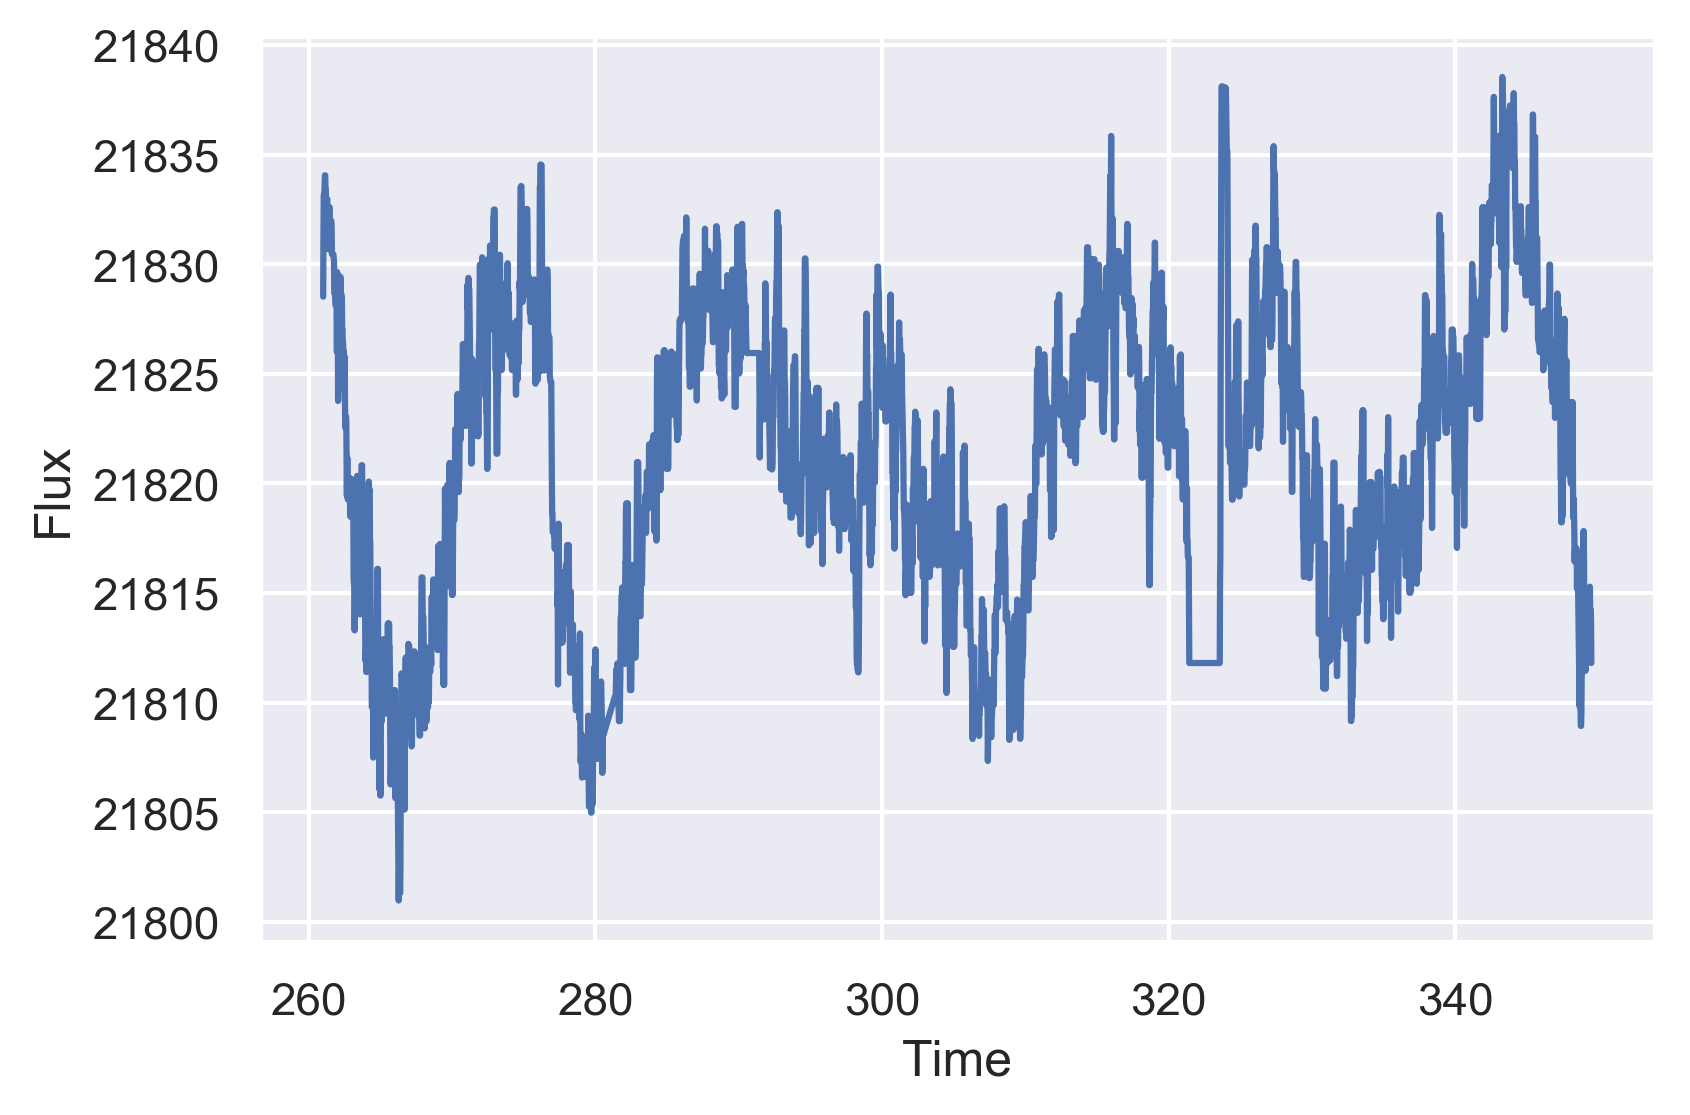

In [9]:
plt.figure(1,dpi=300)
sns.lineplot(df_reduced.TIME,df_reduced.MEDIAN)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

### Curve Fitting - Test

In [10]:

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])
    
    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

In [11]:
tt = df_reduced.TIME
yy = df_reduced.MEDIAN
yynoise = df_reduced.PDCSAP_FLUX
res = fit_sin(df_reduced.TIME, df_reduced.MEDIAN)

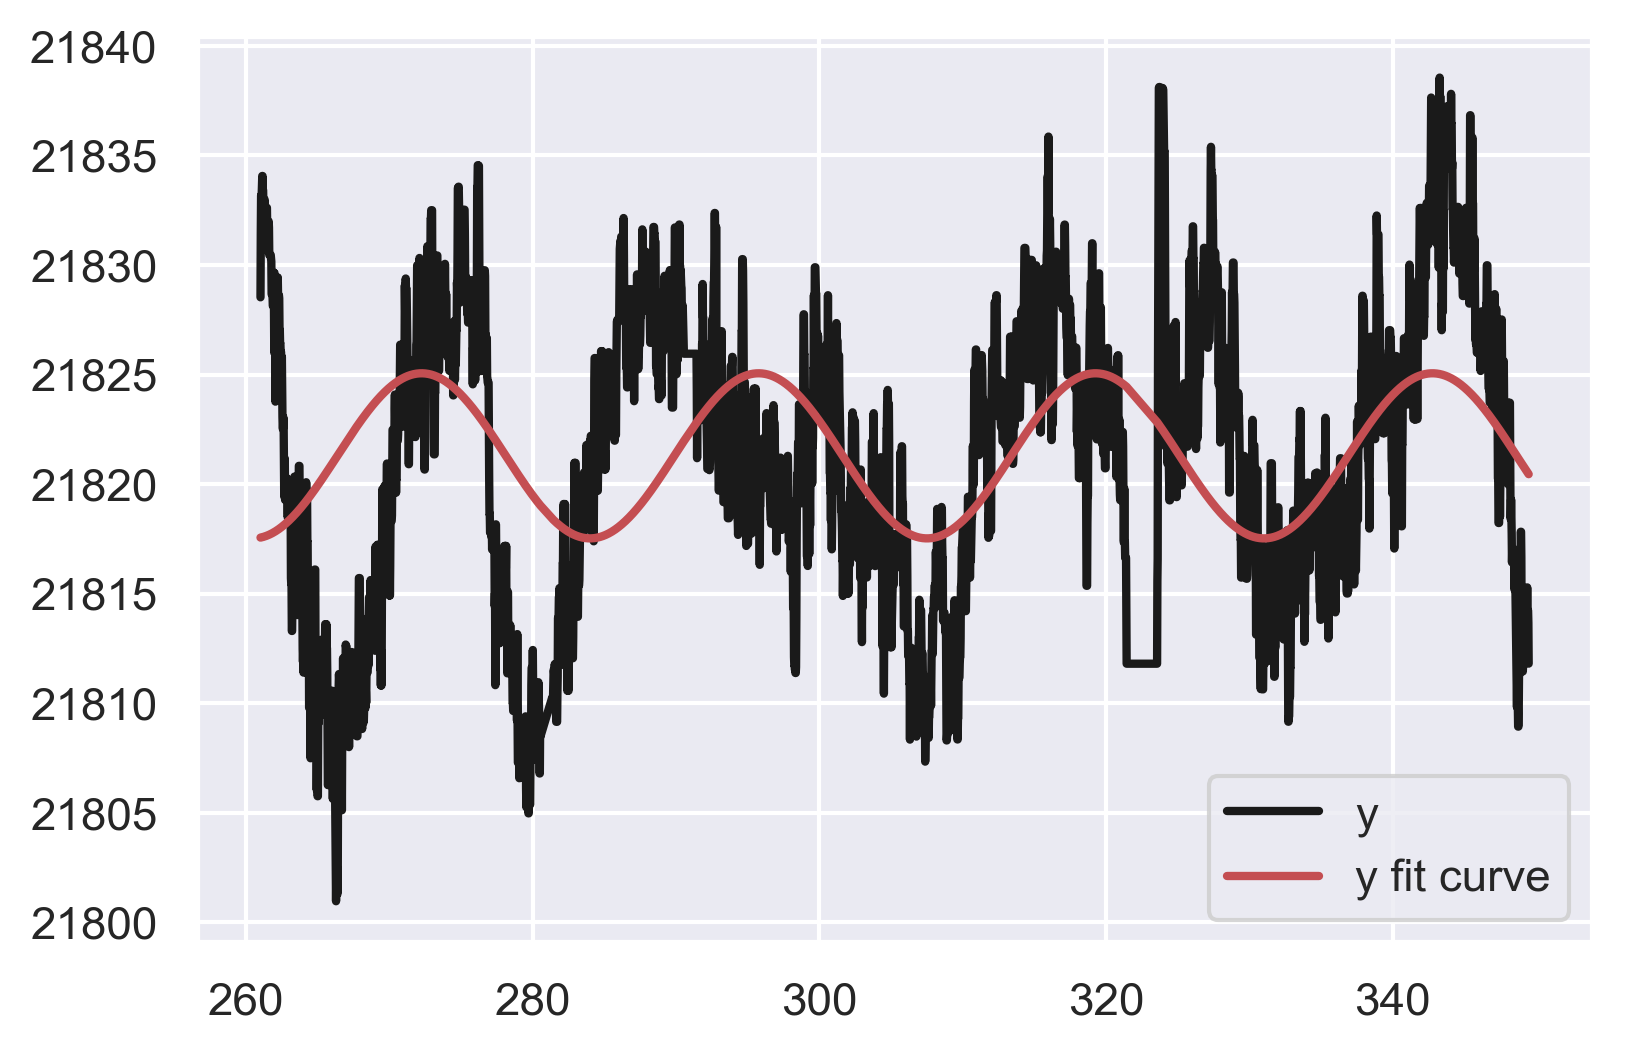

In [12]:
plt.figure(1,dpi=300)
plt.plot(tt, yy, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.show()